In [1]:
import numpy as np
import healpy as hp
import pandas as pd
from scipy import integrate
import astropy.io.fits as fits
import matplotlib.pyplot as plt
from astropy.cosmology import Planck15 as cosmo

In [2]:
from completeness import create_completeness_dataframe

In [3]:
gkvInputCatv02_raw = fits.open('/home/farnoosh/farnoosh/Master_Thesis_all/Data/GAMA/gkvInputCatv02/gkvInputCatv02.fits')[1].data
SM_cat_raw = fits.open('/home/farnoosh/farnoosh/Master_Thesis_all/Data/GAMA/merged/StellarMass-gkvScience/mergedStellarMass-gkvScience')[1].data

print('the file is open, and it has',len(SM_cat_raw), 'number of objects')

the file is open, and it has 370116 number of objects


In [62]:
# Masks

z_max = 0.1 # ~430 Mpc
MASS_BINS = 10**np.arange(5,12.25,0.25)

REGIONS_OF_SKY = {
    # 'G02': {'RAcen': (30.20, 38.80), 'DECcen': (-10.25, -3.72)},
    'G09': {'RAcen': (129.0, 141.0), 'DECcen': (-2.0, 3.0)},
    'G12': {'RAcen': (174.0, 186.0), 'DECcen': (-3.0, 2.0)},
    'G15': {'RAcen': (211.5, 223.5), 'DECcen': (-2.0, 3.0)},
    'G23': {'RAcen': (339.0, 351.0), 'DECcen': (-35.0, -30.0)},
}


GKV_MASKS = (
    (gkvInputCatv02_raw['uberclass'] == 1) &
    (gkvInputCatv02_raw['flux_rt'] > 10**-4.3) &
    (~gkvInputCatv02_raw['duplicate']) &
    (~gkvInputCatv02_raw['mask']) &
    (~gkvInputCatv02_raw['starmask'])
)
gkvInputCatv02 = gkvInputCatv02_raw[GKV_MASKS]


COMPLETENESS_MASKS = (
    (~SM_cat_raw['duplicate']) &
    (~SM_cat_raw['mask']) &
    (~SM_cat_raw['starmask']) &
    (SM_cat_raw['uberclass'] == 1) &
    (SM_cat_raw['flux_rt'] > 10**-4.3)
)

MASS_HISTOGRAM_MASKS = (
         (SM_cat_raw['uberclass'] == 1 ) & #galaxy
         (SM_cat_raw['duplicate'] == False) &
         (SM_cat_raw['mask'] == False) &
         (SM_cat_raw['starmask'] == False) &
         (SM_cat_raw['NQ'] > 2) &
         (SM_cat_raw['SC'] > 7) &
         (SM_cat_raw['Z'] < z_max) &
         (SM_cat_raw['flux_rt'] > 10**(-4.3))
)

completeness_catalog = SM_cat_raw[COMPLETENESS_MASKS]
mass_histogram_catalog = SM_cat_raw[MASS_HISTOGRAM_MASKS]
print('mergedStellarMass_gkvScience, number of objects with SPEC_MASK:', len(completeness_catalog))
print('mass_histogram_catalog, number of objects with masks:',len(mass_histogram_catalog))

mergedStellarMass_gkvScience, number of objects with SPEC_MASK: 197174
mass_histogram_catalog, number of objects with masks: 21619


In [31]:
MS_regions = ['G09', 'G12', 'G15', 'G23']
MS = {region_name: REGIONS_OF_SKY[region_name] for region_name in MS_regions}

MS_SM_cat = {region_name: mass_histogram_catalog[(
    (mass_histogram_catalog['RAcen'] >= region_params['RAcen'][0]) & (mass_histogram_catalog['RAcen'] <= region_params['RAcen'][1]) &
    (mass_histogram_catalog['DECcen'] >= region_params['DECcen'][0]) & (mass_histogram_catalog['DECcen'] <= region_params['DECcen'][1])
) ] for region_name, region_params in MS.items()}

In [70]:
# Functions

# Function to get the weighted histogram divided by the volume
def divide_histogram_by_volume(input_mass_completeness_dataframe: pd.DataFrame, region_name: str):
    mass_histogram = get_weighted_mass_histogram(input_mass_completeness_dataframe=input_mass_completeness_dataframe, region_name=region_name)
    volume = get_volume(region_name=region_name)
    return mass_histogram / volume

# Function to get the volume
def get_volume(region_name: str):
    region = REGIONS_OF_SKY[region_name]
    region_area = calculate_patch_area(patch=region, nside=4096)
    fraction = region_area / total_area_sphere
    return calculate_volume(cosmo.comoving_distance(z_max), fraction)



# Function to get the weighted histogram of the objects of each region
def get_weighted_mass_histogram(input_mass_completeness_dataframe: pd.DataFrame, region_name: str):
    filtered_by_region_dataframe = input_mass_completeness_dataframe[input_mass_completeness_dataframe['region'] == region_name]
    mass_column = filtered_by_region_dataframe['mstar']
    completeness_column = filtered_by_region_dataframe['completeness']
    return np.histogram(mass_column, MASS_BINS, weights=1/completeness_column)[0]

# Function to calculate the area for a given patch
def calculate_patch_area(patch: dict, nside: int=4096):
    RA_min, RA_max = np.deg2rad(patch['RAcen'])
    DEC_min, DEC_max = np.deg2rad(patch['DECcen'])

    # Calculate the pixel indices for the given patch
    pix_indices = np.arange(hp.nside2npix(nside))
    pix_indices_patch = pix_indices[
        (hp.pixelfunc.pix2ang(nside, pix_indices)[0] >= np.pi/2 - DEC_max) &
        (hp.pixelfunc.pix2ang(nside, pix_indices)[0] <= np.pi/2 - DEC_min) &
        (hp.pixelfunc.pix2ang(nside, pix_indices)[1] >= RA_min) &
        (hp.pixelfunc.pix2ang(nside, pix_indices)[1] <= RA_max)
    ]

    # Calculate the area of the given patch using the average solid angle of a pixel
    average_pixel_area = 4 * np.pi / (12 * nside**2)
    patch_area = len(pix_indices_patch) * average_pixel_area

    return patch_area


# Function to calculate volume (Mpc^3)
def calculate_volume(radius, fraction):
    return 4 / 3 * np.pi * radius ** 3 * fraction

# Function to calculate error
def calculate_error(y_data, N):
    return np.sqrt((y_data * N**(-1/2))**2 + (y_data * 0.043)**2)

In [7]:
# Healpy

nside = 4096    # highest resolution
average_pixel_area = 4 * np.pi / (12 * nside**2)
total_area_sphere = hp.nside2npix(nside) * average_pixel_area
np.set_printoptions(precision=5)

# Area and fraction of patches
for region_name, region in REGIONS_OF_SKY.items():
    region_area = calculate_patch_area(region, nside)
    fraction = region_area / total_area_sphere

# Calculate the total area of the patches
total_area_regions = sum(calculate_patch_area(region, nside) for region in REGIONS_OF_SKY.values())

In [71]:
# Dictionary of mass histogram

dict_mass_hist = {}
dict_simple_mass_hist = {}
for region_name in REGIONS_OF_SKY.keys():
    Mass_obj = MS_SM_cat[region_name]['mstar']  # in units of M_{sun}
    m_histogram = np.histogram(Mass_obj, MASS_BINS)[0]  # number of objects is in each bin
    dict_mass_hist[region_name] = m_histogram
    m_histogram_weighted = m_histogram / 0.95  # N(w) = numbers of the object is in each bin / (average completeness)
    dict_simple_mass_hist[region_name] = m_histogram_weighted
    print(m_histogram)

# Dictionary of volumes

dict_regions_volumes = {}
for region_name, region in REGIONS_OF_SKY.items():
    region_volume = calculate_volume(cosmo.comoving_distance(z_max), fraction)
    dict_regions_volumes[region_name] = region_volume

# N(w)/V: weighted number density over volume

dict_mass_func = {}
for region_name in REGIONS_OF_SKY.keys():
    dict_mass_func[region_name] = dict_simple_mass_hist[region_name] / dict_regions_volumes[region_name]
print(dict_mass_func)

[  0   1   0   1   1   3   2   3   3   5  13  42  64 138 207 362 565 653
 553 554 467 389 264 153  48   7   0   0]
[  0   0   0   2   3   5   6   3  15  19  24  68 103 149 237 420 743 912
 917 833 661 606 415 207  69  10   0   0]
[  0   1   0   0   1   0   3   2   3  13  19  35 106 191 330 503 723 729
 728 591 588 469 313 159  53   7   1   0]
[  0   0   0   0   0   0   4   5   2   7   8  17  38  97 156 340 602 744
 731 661 589 488 364 170  70  19   2   0]
{'G09': <Quantity [0.00000e+00, 2.53496e-06, 0.00000e+00, 2.53496e-06, 2.53496e-06,
           7.60489e-06, 5.06992e-06, 7.60489e-06, 7.60489e-06, 1.26748e-05,
           3.29545e-05, 1.06468e-04, 1.62238e-04, 3.49825e-04, 5.24737e-04,
           9.17656e-04, 1.43225e-03, 1.65533e-03, 1.40183e-03, 1.40437e-03,
           1.18383e-03, 9.86100e-04, 6.69230e-04, 3.87849e-04, 1.21678e-04,
           1.77447e-05, 0.00000e+00, 0.00000e+00] 1 / Mpc3>, 'G12': <Quantity [0.00000e+00, 0.00000e+00, 0.00000e+00, 5.06992e-06, 7.60489e-06,
        

/tmp/ipykernel_68243/2211073561.py:51: RuntimeWarning: divide by zero encountered in power
  return np.sqrt((y_data * N**(-1/2))**2 + (y_data * 0.043)**2)
/home/farnoosh/.local/lib/python3.10/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


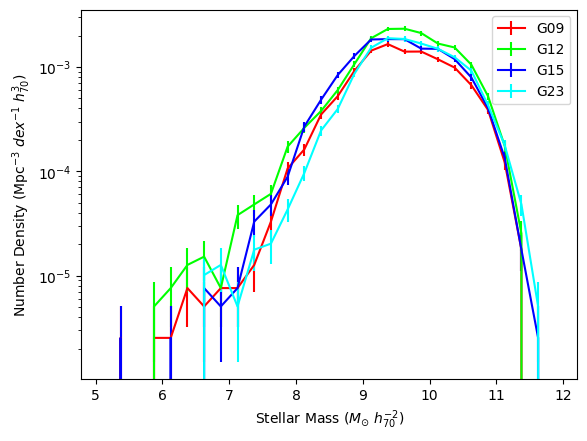

In [72]:
# Plot
region_colors = {'G09': 'red', 'G12': 'lime', 'G15': 'blue', 'G23': 'cyan'}

for region_name in REGIONS_OF_SKY.keys():
    errors = calculate_error(dict_mass_func[region_name], dict_mass_hist[region_name])
    plt.errorbar(np.log10(MASS_BINS[:-1])+(0.25/2), dict_mass_func[region_name], yerr=errors,
             label=region_name, color=region_colors[region_name])

plt.xlabel('Stellar Mass ($M_{\odot} \ h_{70}^{-2}$)')
plt.ylabel('Number Density ($\mathrm{Mpc}^{-3} \ dex^{-1} \ h_{70}^{3}$)')
plt.yscale('log')
plt.legend()
plt.show()

In [42]:
completeness_all_df = pd.DataFrame()

# Loop over regions and create completeness DataFrames
for region_name, region_params in REGIONS_OF_SKY.items():
    # completeness_region_df = pd.DataFrame()
    completeness_region_df = create_completeness_dataframe(big_survey=gkvInputCatv02,
                                                           small_survey=completeness_catalog,
                                                           flux_type='flux_rt',
                                                           region=region_name)
    completeness_region_df['region'] = region_name
    completeness_all_df = pd.concat([completeness_all_df, completeness_region_df], ignore_index=True)
print(completeness_all_df)

/home/farnoosh/Nextcloud/MasterThesis/codes/jupyternotebooks/completeness.py:34: RuntimeWarning: invalid value encountered in divide
  return np.cumsum(number_of_obj_small_survey)/np.cumsum(number_of_obj_big_survey)
/home/farnoosh/Nextcloud/MasterThesis/codes/jupyternotebooks/completeness.py:34: RuntimeWarning: invalid value encountered in divide
  return np.cumsum(number_of_obj_small_survey)/np.cumsum(number_of_obj_big_survey)
/home/farnoosh/Nextcloud/MasterThesis/codes/jupyternotebooks/completeness.py:34: RuntimeWarning: invalid value encountered in divide
  return np.cumsum(number_of_obj_small_survey)/np.cumsum(number_of_obj_big_survey)
/home/farnoosh/Nextcloud/MasterThesis/codes/jupyternotebooks/completeness.py:34: RuntimeWarning: invalid value encountered in divide
  return np.cumsum(number_of_obj_small_survey)/np.cumsum(number_of_obj_big_survey)


                 uberID  completeness region
0       138021052006945      0.963282    G09
1       131010293406270      0.903144    G09
2       136000563202354      0.900658    G09
3       130020205007803      0.958731    G09
4       132990039308055      0.958082    G09
...                 ...           ...    ...
197167  341690286909859      0.768362    G23
197168  339670781606938      0.723267    G23
197169  346700890705873      0.852356    G23
197170  338690341704233      0.873429    G23
197171  342670256912301      0.635205    G23

[197172 rows x 3 columns]


In [47]:
mass_histogram_catalog_dataframe = pd.DataFrame()
mass_histogram_catalog_dataframe['uberID'] = mass_histogram_catalog['uberID'].byteswap().newbyteorder()
mass_histogram_catalog_dataframe['mstar'] = mass_histogram_catalog['mstar'].byteswap().newbyteorder()

In [51]:
# Merge completeness DataFrame with mass_histogram_catalog_dataframe based on 'uberID'
full_mass_completeness_dataframe = pd.merge(mass_histogram_catalog_dataframe, completeness_all_df,
                            on='uberID', how='left')

In [68]:
print(get_weighted_mass_histogram(input_mass_completeness_dataframe=full_mass_completeness_dataframe,region_name='G12'))


[  0.        0.        0.        2.07283   3.07516   5.16425   6.16369
   3.08043  15.41748  19.46359  24.71557  70.25645 106.17141 153.26004
 243.84946 433.41302 766.34258 937.96568 940.37116 851.8225  674.78262
 618.16995 423.13486 211.02009  70.33438  10.19306   0.        0.     ]


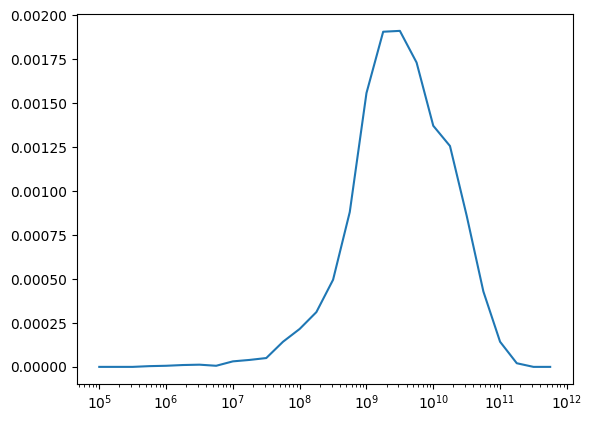

In [69]:
plt.plot(MASS_BINS[:-1], divide_histogram_by_volume(input_mass_completeness_dataframe=full_mass_completeness_dataframe, region_name='G12') )
plt.xscale('log')

In [154]:
print(cosmo.comoving_distance(z_max))

432.1244883487781 Mpc


In [155]:
def richard_curve(x):
    """
    Richards curve from GAMA based on Table 5, Eq. 2 from Driver et al. 2022
    :param x: log10 of stellar mass limit
    :return: co moving distance  in Mpc
    """
    A = -0.016
    K = 2742.0
    C = 0.9412
    B = 1.1483
    M = 11.815
    nu = 1.691
    y = A + (K - A) / (C + np.exp(-B * (x - M))) ** (1 / nu)
    return y

In [156]:
Mstar = np.log10(mass_histogram_catalog['mstar'])[np.log10(mass_histogram_catalog['mstar'])>8]
DMAX = richard_curve(Mstar)-richard_curve(8)
DMAX[DMAX>430]=430
DMAX[DMAX<0.01]=0.01

/tmp/ipykernel_68243/871560155.py:1: RuntimeWarning: invalid value encountered in log10
  Mstar = np.log10(mass_histogram_catalog['mstar'])[np.log10(mass_histogram_catalog['mstar'])>8]


In [1]:
Mval=np.arange(8,12,0.1)
plt.plot(Mval, richard_curve(Mval)-richard_curve(8))
plt.axhline(430)
plt.ylim((0,500))

NameError: name 'np' is not defined

(array([ 546., 1138., 2586., 4190., 4268., 3515., 2911., 1610.,  459.,
          45.]),
 array([ 8.00032,  8.3618 ,  8.72328,  9.08475,  9.44623,  9.80771,
        10.16918, 10.53066, 10.89214, 11.25362, 11.61509]),
 <BarContainer object of 10 artists>)

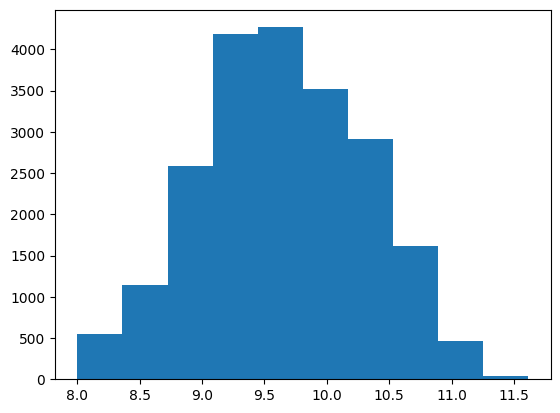

In [158]:
plt.hist(Mstar)

(array([  381.,   586.,   762.,  1078.,  1458.,  1637.,  1651.,  1556.,
         1437., 10722.]),
 array([4.43420e-02, 4.30399e+01, 8.60355e+01, 1.29031e+02, 1.72027e+02,
        2.15022e+02, 2.58018e+02, 3.01013e+02, 3.44009e+02, 3.87004e+02,
        4.30000e+02]),
 <BarContainer object of 10 artists>)

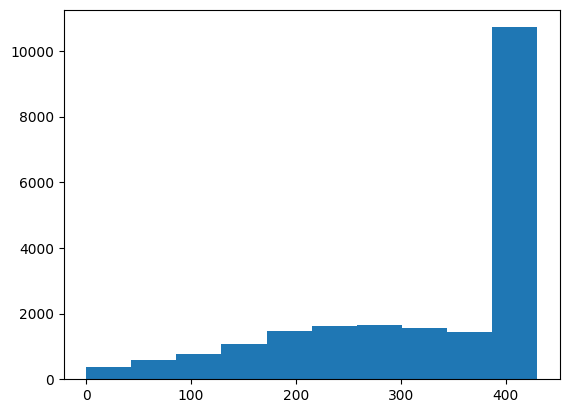

In [159]:
plt.hist(DMAX)

(array([3698., 1930., 1417., 1116.,  864.,  741.,  603.,  560.,  472.,
        9867.]),
 array([3.65204e-04, 3.33038e+07, 6.66076e+07, 9.99114e+07, 1.33215e+08,
        1.66519e+08, 1.99823e+08, 2.33127e+08, 2.66431e+08, 2.99734e+08,
        3.33038e+08]),
 <BarContainer object of 10 artists>)

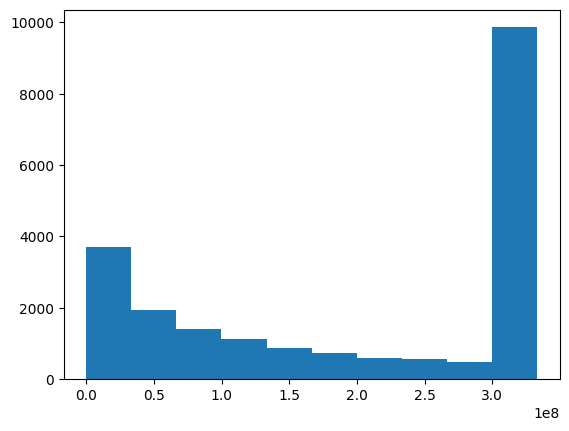

In [160]:
V_max = DMAX**3 * 4 * np.pi / 3.
plt.hist(V_max)

In [161]:
m_bins = np.arange(8,12,0.1)
N_w = np.histogram(Mstar, weights = 0.0071/V_max/0.95, bins = 100)
print(-N_w[1][:-1]+N_w[1][1:])

[0.03615 0.03615 0.03615 0.03615 0.03615 0.03615 0.03615 0.03615 0.03615
 0.03615 0.03615 0.03615 0.03615 0.03615 0.03615 0.03615 0.03615 0.03615
 0.03615 0.03615 0.03615 0.03615 0.03615 0.03615 0.03615 0.03615 0.03615
 0.03615 0.03615 0.03615 0.03615 0.03615 0.03615 0.03615 0.03615 0.03615
 0.03615 0.03615 0.03615 0.03615 0.03615 0.03615 0.03615 0.03615 0.03615
 0.03615 0.03615 0.03615 0.03615 0.03615 0.03615 0.03615 0.03615 0.03615
 0.03615 0.03615 0.03615 0.03615 0.03615 0.03615 0.03615 0.03615 0.03615
 0.03615 0.03615 0.03615 0.03615 0.03615 0.03615 0.03615 0.03615 0.03615
 0.03615 0.03615 0.03615 0.03615 0.03615 0.03615 0.03615 0.03615 0.03615
 0.03615 0.03615 0.03615 0.03615 0.03615 0.03615 0.03615 0.03615 0.03615
 0.03615 0.03615 0.03615 0.03615 0.03615 0.03615 0.03615 0.03615 0.03615
 0.03615]


(1e-05, 1)

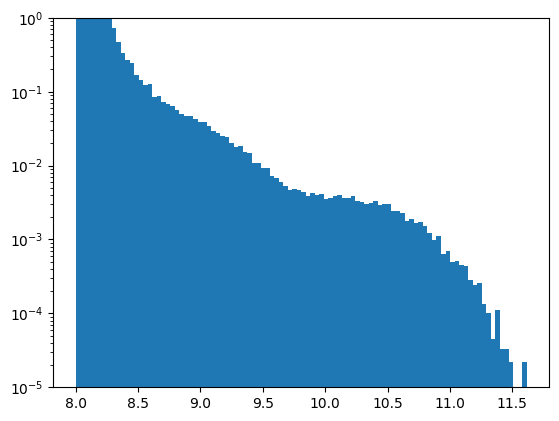

In [162]:
plt.hist(Mstar, weights = 1e5* 0.0071/V_max/0.95/0.03/np.log(10)*0.7**3, bins=100)
plt.yscale('log')
plt.ylim((1e-5, 1))

In [166]:
np.log10(mass_histogram_catalog['mstar']).min()


/tmp/ipykernel_68243/3396587275.py:1: RuntimeWarning: invalid value encountered in log10
  np.log10(mass_histogram_catalog['mstar']).min()


nan

In [167]:
V_max.min()


0.0003652041

In [168]:
mass_histogram_catalog['mstar']


array([1.08714e+10, 1.90287e+09, 9.15271e+09, ..., 1.56962e+10,
       9.14959e+07, 1.05476e+08], dtype=float32)